In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
def genData():
    center1 = np.array([4,4])
    center2 = np.array([8,10])
    center3 = np.array([12,14])
    
    m1 = 100
    m2 = 100
    m3 = 100
    
    # Generate data for center 1
    X1 = center1 + np.random.rand(m1, center1.shape[0])*4
    Y1 = np.zeros([m1,1])
    
    # Generate data for center 2
    X2 = center2 + np.random.rand(m2, center2.shape[0])*4
    Y2 = np.ones([m2,1])
    
    # Generate data for center 2
    X3 = center3 + np.random.rand(m3, center3.shape[0])*4
    Y3 = np.zeros([m3,1])
    
#     X = np.concatenate((X1, X2), axis=0)
#     Y = np.concatenate((Y1, Y2), axis=0)
    X = np.concatenate((X1, X2, X3), axis=0)
    Y = np.concatenate((Y1, Y2, Y3), axis=0)
    Y = Y.reshape((Y.shape[0], 1))
    
    return X,Y,X1,X2

In [3]:
test,test_Y,_,_ = genData()
print(test.shape)
print(test_Y.shape)

(300, 2)
(300, 1)


In [0]:
# X_train: input of training data (#data x #feature)
# Y_train: output of training data (#data x #output)
# num_step: hyperparam - number of learning step (scalar)
# lr: hyperparam - learning rate
# layer_dim : hyperparam - number of neurons of each hidden layer list(#hidden_layer)
class model():
    
    # X_train: input of training data (#data x #feature)
    # Y_train: output of training data (#data x #output)
    # num_step: hyperparam - number of learning step (scalar)
    # lr: hyperparam - learning rate
    # layer_dim : hyperparam - number of neurons of each hidden layer list(#hidden_layer)
    def __init__(self,
                 X_train,
                 Y_train,
                 n_step = 10000,
                 lr = 0.1,
                 hidden_layer_dim = None):
        self.X_train = X_train
        self.Y_train = Y_train
        self.n_step = n_step
        self.lr = lr
        
        self.n_data = X_train.shape[0]
        self.input_dim = X_train.shape[1]
        self.output_dim = Y_train.shape[1]
        
        self.layer_dim = []
        # Add #input to layer_dim
        self.layer_dim.append(self.input_dim)
        
        # Add all #hidden_layer to layer_dim
        self.layer_dim.extend(hidden_layer_dim)
        
        # Add #output to layer_dim
        self.layer_dim.append(self.output_dim)
        
        self.parameters = {}
        
    def initialize_layer_weight(self):
        np.random.seed(2)
        L = len(self.layer_dim)

        for l in range(1, L):
          self.parameters["W" + str(l)] = np.random.rand(self.layer_dim[l], self.layer_dim[l-1]) * 0.01
          self.parameters["b" + str(l)] = np.zeros([self.layer_dim[l], 1], dtype = float)
      
    def activation_forward(self, Z, activation_name):
        if activation_name == 'sigmoid':
          A = 1 / (1 + np.exp(-Z))
        elif activation_name == 'relu':
          A = np.maximum(0,Z)

        return A
      
          
    def linear_forward(self, A_prev, W, b):
        Z = np.dot(W, A_prev) + b
        return Z
      
    def layer_forward(self, A_prev, W, b, activation_name = "sigmoid"):
        Z = self.linear_forward(A_prev, W, b)
        A_next = self.activation_forward(Z, activation_name)
          
        cache = (A_prev, W, b, Z)
        return A_next, cache
      
    def model_forward(self, X, parameters):
      caches = []
      
      L = len(self.layer_dim)
      
      # Current A of input layer is X
      A = X
      
      # Forward from input layer to last hidden layer
      for l in range(1,L - 1):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A, cache = self.layer_forward(A_prev, W, b, activation_name = "relu")
        caches.append(cache)

      # Forward from last hidden layer to output layer
      A_prev = A
      W = parameters["W" + str(L-1)]
      b = parameters["b" + str(L-1)]
      AL, cache = self.layer_forward(A_prev, W, b, activation_name = "sigmoid")
      caches.append(cache)
      
      return AL, caches
    
    def model_backward(self, AL, Y, caches):
      L = len(self.layer_dim)
      m = self.Y_train.shape[0] * 1.0
      Y = Y.reshape(AL.shape)
      grads = {}
      
      # Derrivative of last layer
      current_cache = caches[L - 2]
      dAL = -(Y / AL - (1 - Y) / (1 - AL))
      
      dA = dAL
      A_next = AL
      
      dA, grads["dW" + str(L-1)], grads["db" + str(L-1)] = self.layer_backward(A_next, dA, current_cache, "sigmoid")
    
      A_next, _ , _ , _ = current_cache
      
      # Derivative of l th layer
      for l in reversed(range(1,L-1)):
        current_cache = caches[l-1]
        dA, grads["dW" + str(l)], grads["db" + str(l)] = self.layer_backward(A_next, dA, current_cache, "relu")
        A_next, _ , _ , _ = current_cache
      
      return grads
    
    def layer_backward(self, A, dA, cache, activation_name):
      dZ = self.activation_backward(A, dA, activation_name)
      dA_prev, dW, db = self.linear_backward(dZ, cache)
      
      return dA_prev, dW, db
    
    def activation_backward(self, A, dA, activation_name):
        if activation_name == 'sigmoid':
          dZ = A * (1 - A) * dA
        elif activation_name == 'relu':
          dZ = np.array(dA, copy=True)
          dZ[A == 0] = 0

        return dZ
    
    def linear_backward(self, dZ, cache):
      m = self.Y_train.shape[0] * 1.0
      A_prev, W, b, Z = cache
      
      dW = 1/m * np.dot(dZ, np.transpose(A_prev))
      db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
      dA_prev = np.dot(np.transpose(W), dZ)
      
      return dA_prev, dW, db
    
    def update_param(self, parameters, grads, learning_rate):
      L = len(self.layer_dim)
      
      for l in range(1, L):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]
        
      return parameters
    
    def compute_loss(self, AL, Y):
      m = self.Y_train.shape[0] * 1.0
      
      loss = -1/m * np.sum(Y*np.log(AL) + (1-Y)*np.log(1-AL))
      return loss
    
    def train(self):
      
      X = self.X_train.T
      Y = self.Y_train.T
      self.initialize_layer_weight()
      loss = 1000
      i = 0
      
      for i in range(self.n_step):
        AL, caches = self.model_forward(X, self.parameters)
  
        grads = self.model_backward(AL, Y, caches)

        self.parameters = self.update_param(self.parameters, grads, self.lr)
      
        if ((i+1)% (self.n_step/10) == 0):
          loss = self.compute_loss(AL,Y)
          print(loss)
      
      return

In [5]:
X,Y,X1,X2 = genData()
model1 = model(X_train = X,
               Y_train = Y,
               n_step = 17000,
               lr = 0.02,
               hidden_layer_dim = [10]
              )
model1.train()

0.5921858692407226
0.583339579593201
0.5608943386432655
0.4283531647939528
0.3310629075404371
0.25418083997802393
0.19790313930283637
0.154685498890654
1.585643209111424
0.04791321973231797


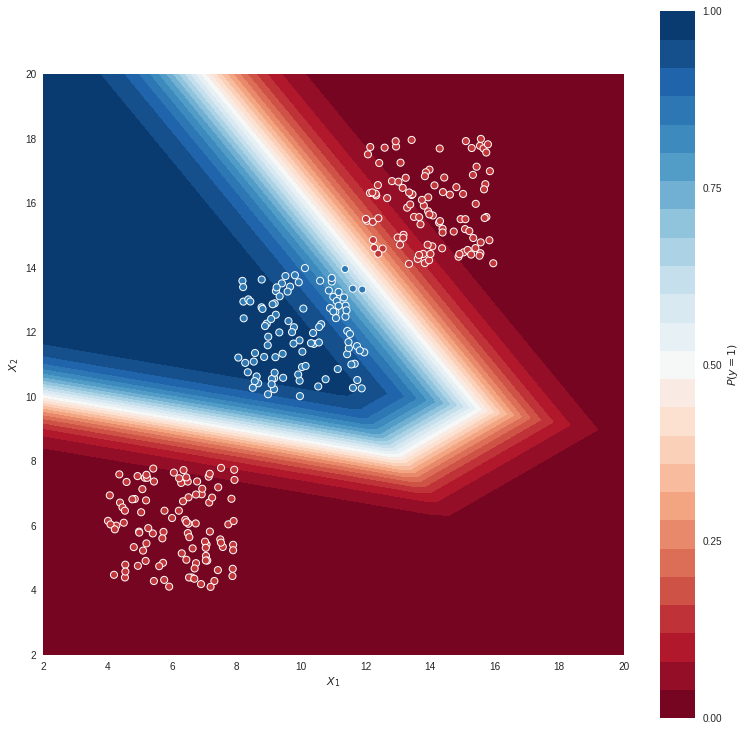

In [6]:
# np.mgrid : Return grid point contain 2:15 x 2:15, with each point is represented by 2 feature -> return tensor 2 x 2:20 x 2:15 
X1_grid, X2_grid = np.mgrid[2:20:.01, 2:20:.01] 

# np.ravel : flatten tensor
grid = np.c_[X1_grid.ravel(), X2_grid.ravel()]
probs, _ = model1.model_forward(np.transpose(grid), model1.parameters)
probs = probs.reshape(X1_grid.shape)

f, ax = plt.subplots(figsize=(13, 13))
contour = ax.contourf(X1_grid, X2_grid, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[:,0], X[:,1], c=Y.reshape(Y.shape[0]), s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(aspect="equal",
       xlim=(2, 20), ylim=(2, 20),
       xlabel="$X_1$", ylabel="$X_2$")

plt.show()